In [81]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import pyFAI
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry

def wavelength_(photon_energy):
    ELEMENTARY_CHARGE = 1.602176634E-19 # C
    SPEED_OF_LIGHT = 299792458 # m/s
    PLANCK_CONSTANT = 6.62607015E-34 # Js
    wavelength = PLANCK_CONSTANT*SPEED_OF_LIGHT/(photon_energy*ELEMENTARY_CHARGE)
    return wavelength
import h5py 
import sys

In [82]:
# --  parameters
run = 1192416
tag = 330809022
det_shape  = [2399,2399]

# -- paths
file_path = '/UserData/maddalena/sacla2022/02-h5compression/1192416_331209002_331209602.h5'
tag_path = 'run_%s/detector_2d_assembled_1/'%run

In [8]:
# load h5 file
f = h5py.File(file_path, 'r')
tags=f[f'/run_{run}/event_info/tag_number_list']

In [4]:
# caclulate the average image
img = np.zeros(det_shape)
for i in tags:
    img_path = f'/run_{run}/detector_2d_assembled_1/tag_{i}/detector_data'
    img += np.array(f[img_path])
img /= len(tags)

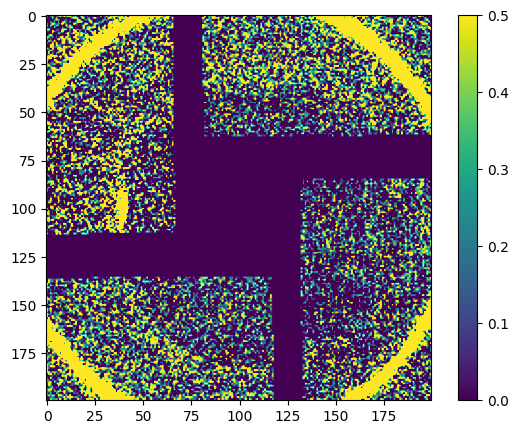

In [79]:
plt.figure(figsize=[7,5])
plt.imshow(img[1100:1300,1100:1300,],vmin=0,vmax=.5)
plt.colorbar()
plt.show()

# Calibration with pyFAI on Jupyter

In [29]:
# This allow to measure approximatively the position of the beam center ...
x = 1200 # x-coordinate of the beam-center in pixels
y = 1200 # y-coordinate of the beam-center in pixels
d = 120 # This is the distance in mm (unit used by Fit2d)


In [62]:
f = h5py.File(file_path, 'r')
energy=np.mean(f[f'/run_{run}/event_info/bl_3/oh_2/photon_energy_in_eV'])
print(energy)
wl = wavelength_(energy) # The wavelength is 1 Å
print(wl)

9028.347
1.373276889246479e-10


In [63]:
# Definition of the detector and of the calibrant:
# pilatus = pyFAI.detector_factory("Pilatus1M")
Pixel1 = 50e-6
Pixel2 = 50e-6
detector = pyFAI.detectors.Detector(pixel1=Pixel1, pixel2=Pixel2, max_shape=[2399,2399]) 

behenate = CALIBRANT_FACTORY("AgBh")
behenate.wavelength = wl
behenate

AgBh Calibrant with 49 reflections at wavelength 1.373276889246479e-10

In [64]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=detector, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Detector	 Spline= None	 PixelSize= 5.000e-05, 5.000e-05 m
Wavelength= 1.373277e-10m
SampleDetDist= 1.200000e-01m	PONI= 6.000000e-02, 6.000000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 120.000mm	Center: x=1200.000, y=1200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [65]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry("demo", img, calibrant=behenate, detector=detector, geometry=initial)
sg.extract_cp(max_rings=7)

ControlPoints instance containing 7 group of point:
AgBh Calibrant with 49 reflections at wavelength 1.373276889246479e-10
Containing 7 groups of points:
#ak ring 0: 320 points
#al ring 1: 203 points
#am ring 2: 361 points
#an ring 3: 361 points
#ao ring 4: 361 points
#ap ring 5: 361 points
#aq ring 6: 361 points

(500.0, 1999.0)

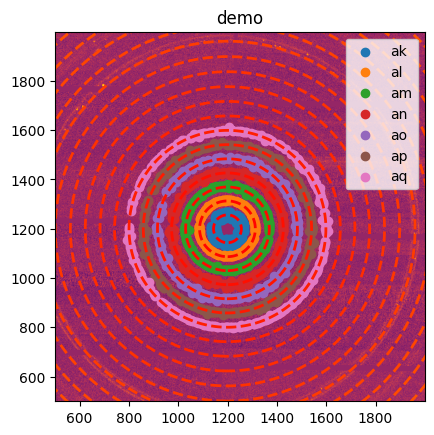

In [66]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
ax = jupyter.display(sg=sg)
ax.set_xlim([500, 1999])
ax.set_ylim([500, 1999])


In [67]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["rot1", "rot2", "rot3", "wavelength"])
sg.get_ai()

Detector Detector	 Spline= None	 PixelSize= 5.000e-05, 5.000e-05 m
Wavelength= 1.373277e-10m
SampleDetDist= 1.203322e-01m	PONI= 6.006195e-02, 5.994644e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 120.332mm	Center: x=1198.929, y=1201.239 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [68]:
#Save the geometry obtained
sg.geometry_refinement.save("geometry.poni")
with open("geometry.poni") as f:
    print(f.read())

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Sat Oct 29 07:43:18 2022
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 5e-05, "pixel2": 5e-05, "max_shape": [2399, 2399]}
Distance: 0.12005383662424948
Poni1: 0.06001296770398906
Poni2: 0.0600075731931693
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1.03e-10
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Sat Oct 29 07:47:26 2022
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 5e-05, "pixel2": 5e-05, "max_shape": [2399, 2399]}
Distance: 0.12015576762553214
Poni1: 0.05999941734891585
Poni2: 0.05998304162208069
Rot1: 0.0
Rot2: 0.0
Rot3: 0
Wavelength: 1.127129076665457e-10
# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Sat Oct 29 08:04:58 2022
poni_version: 2
Detector: Detector
Detector_config: {"pixel1": 5e-05, "pixel2": 5e-05, "max_shape": [2399, 2399]}
Distance: 0.11820404415206555
Poni1: 0.06017248437216183
Poni2: 0

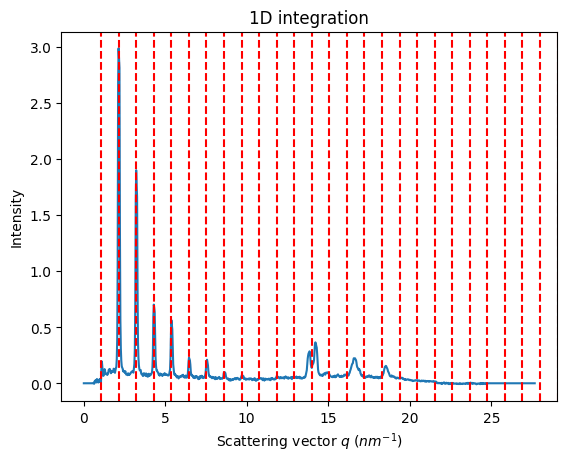

In [80]:
#Use the geometry to perform an azimuthal integration
ai = sg.get_ai()
res = ai.integrate1d(img, 1000)
ax = jupyter.plot1d(res,calibrant=behenate)
#ax.set_xlim(0,10)

In [ ]:
ai.solidAngleArray

In [ ]:

ai.save(f'/UserData/maddalena/sacla2022/04-utilities/geometry_{run}.poni' )


In [103]:
ls /UserData/maddalena/sacla2022/04-utilities

1192416.poni            geometry_1192413.poni*  test
geometry_1192411.poni*  mask.npy*               test.poni


In [56]:
wavelength_(9000)

1.3776022048133363e-10